### Imports

In [1]:
from preparation import *
from model import *

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Configuration Parameters

In [2]:
# First load the data
df = load_data()

number_of_splits = 1
seed = 42
# The following params are used for the random search cross-validation
n_iter = 100
k_fold = 5
n_jobs = -1
verbose = 1

# This parameter is set to True, so 
# `Page total likes` and `Lifetime Post Consumers`
# will be transformed using a PowerTransformer
do_transform = True

# The alternative is, using `do_convert_hour=True`, to transform hour
# into a coordinate system (hour_x, hour_y),
# to deal with the fact that 23:00 is close to 00:00

# However, as this doesn't improve the model
# we leave this conversion out for better clarity.
do_convert_hour = False

## Model Selection

In [3]:
%%time

for X_train, X_test, y_train, y_test, transformer_y in prepare_datasets(
        df,
        number_of_splits=number_of_splits,
        seed=seed,
        do_convert_hour=do_convert_hour,
        do_transform=do_transform
):

    selected_model, results_df = select_model(
        X_train, y_train, regressors_list=REGRESSORS_LIST,
        k_fold=k_fold, n_iter=n_iter, n_jobs=n_jobs, verbose=verbose)
    
    selected_model.fit(X_train, y_train)

    y_train_pred, y_test_pred, y_train, y_test = get_predictions(
        selected_model, X_train, y_train, X_test, y_test, 
        transformer_y=transformer_y)
    
    train_rmse, test_rmse = calc_rmse(y_train_pred, y_test_pred, y_train, y_test)

### Tuning DecisionTreeRegressor... ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


### Tuning Ridge... ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


### Tuning KNeighborsRegressor... ###
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


### Tuning SVR... ###
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


### Tuning RandomForestRegressor... ###
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   48.8s finished


### Tuning XGBRegressor... ###
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.0s finished



### Best model: XGBRegressor ###
Wall time: 1min 24s


Let's see the selected model and compare the regressors

In [4]:
print('The selected model is:\n')

print(selected_model)

print('\nTrain RMSE = {:.01f}, Test RMSE = {:.01f}'.format(
    train_rmse, test_rmse))

The selected model is:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8000000000000003, gamma=0.4,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_delta_step=0, max_depth=3,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=30, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Train RMSE = 660.4, Test RMSE = 530.8


We will now see the results of the selection process in terms of the average test score, average prediction time and fit time.

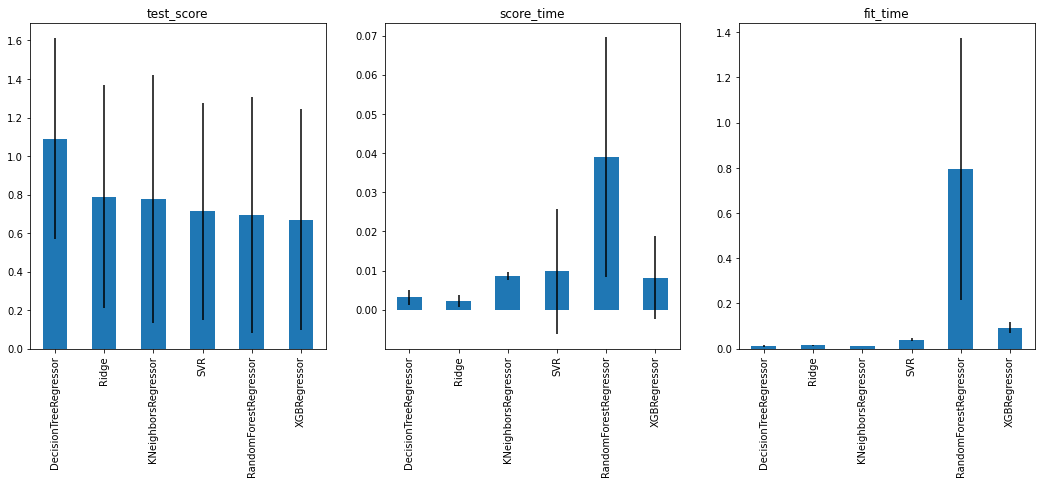

In [5]:
results_df.loc['mean_test_score'] = -results_df.loc['mean_test_score']
num = len(results_df.index)
fig, axes = plt.subplots(1, num // 2, figsize=(18, 6))
for i in range(0, num, 2):
    results_df.iloc[i, :].plot.bar(
        ax=axes[i // 2],
        yerr=results_df.iloc[i + 1, :] * 1.96
    )
    axes[i // 2].set_title(results_df.index[i][5:])

The difference in score from the Random Forest is not that high, however the Random Forest seems to be really slow in fitting and predicting.

Note that the test_score here is the root mean squared error of the normalised y variable, and it is shown for comparison purposes.

We can also see the important features:

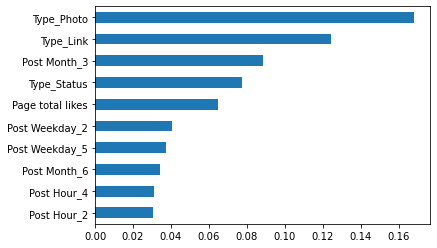

In [6]:
if type(selected_model).__name__ in ['RandomForestRegressor', 'XGBRegressor']:
    pd.Series(selected_model.feature_importances_, 
              index=X_train.columns).sort_values().tail(10).plot.barh();

`Link` is the most important feature, followed by `Photo`.

Lets's now see the fit in a grid:

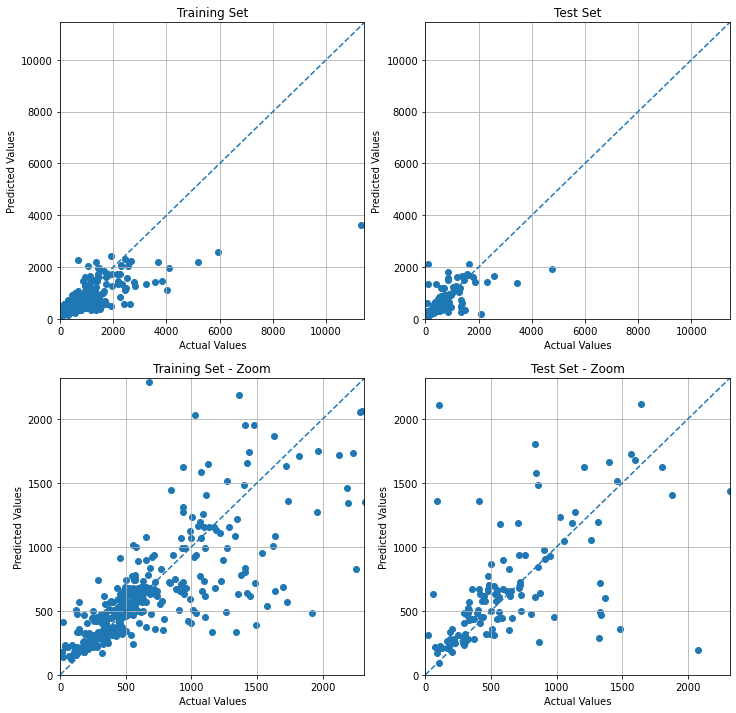

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].scatter(y_train, y_train_pred)
axes[0, 0].set_title('Training Set')
axes[1, 0].scatter(y_train, y_train_pred)
axes[1, 0].set_title('Training Set - Zoom')
axes[0, 1].scatter(y_test, y_test_pred)
axes[0, 1].set_title('Test Set')
axes[1, 1].scatter(y_test, y_test_pred)
axes[1, 1].set_title('Test Set - Zoom')

# Set the axis limits
# First we find the max value of y
y = np.concatenate([y_train, y_test])
# We use 101% of the max value for the top scatterplots
ymax = np.max(y) * 1.01
# And the 95th percentile for the zoomed scatterplots
yperc95 = np.percentile(y, 95)

axes[0, 0].set_xlim([0, ymax])
axes[0, 0].set_ylim([0, ymax])

axes[0, 1].set_xlim([0, ymax])
axes[0, 1].set_ylim([0, ymax])

axes[1, 0].set_xlim([0, yperc95])
axes[1, 0].set_ylim([0, yperc95])

axes[1, 1].set_xlim([0, yperc95])
axes[1, 1].set_ylim([0, yperc95])

for axx in axes:
    for ax in axx:
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')

        # draw the diagonal line to compare with the perfect fit
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--")
        
        ax.grid()

The model clearly suffers from high bias, as it is unable to predict the higher values.